In [2]:
# 데이터 분석을 위한 패키지
import numpy as np
import pandas as pd

In [3]:
# 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import FinanceDataReader as fdr

In [5]:
import koreanize_matplotlib

In [6]:
import datetime
from dateutil.relativedelta import relativedelta

In [7]:
from data_loader import load_sector_data

In [8]:
# 모든 컬럼,행을 출력하도록 설정
pd.set_option('display.max_columns', None) # None으로 설정하면 모든 컬럼 출력
pd.set_option('display.max_rows', None) #None으로 설정하면 모든 행 출력

In [9]:
# n개월 전 날짜 계산 함수(개월단위)
def calculate_start_date(months_ago, end_date):
    start_date = datetime.datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(months=months_ago)
    return start_date.strftime('%Y-%m-%d')

# 오늘 날짜 구하기
today = datetime.datetime.today()
today_str = today.strftime('%Y-%m-%d')

In [49]:
# 시장과 기간을 입력받아, 모든 종목을 돌면서 수익률을 반환해주는 함수

def return_by_stock(market='KOSPI', month_ago = 1, end_date=today_str):
  
  start_date = calculate_start_date(month_ago, end_date)
  
  results = [] # 수익률 결과를 저장할 리스트
  
  market_list= fdr.StockListing(market)
  
  try:
    
    for stock in market_list['Code'].tolist():
      data = fdr.DataReader(stock, start=start_date, end=end_date)[['Close']]
      
      if data.empty:  # 데이터가 비어있는지 확인
        print(f"종목 {stock}의 데이터가 없습니다. 건너뜁니다.")
        continue
      
      # 일일 수익률
      data['return'] = data.pct_change()
      
      # NaN 값 처리: 첫 번째 행 삭제
      data = data.dropna()
      
      # 수익률을 퍼센트로 변환
      data['return'] = data['return'] * 100
      
      # 499790, 177900, 487360 코드에서 오류발생
      # 데이터를 가져오는 중 오류가 발생했습니다: single positional indexer is out-of-bounds : 특정 인덱스에 접근할 때 그 인덱스가 존재하지 않는 경우
      # 상장된지 얼마 되지않아, 단 '하루'의 데이터만 존재하는경우, pct_change()를 호출하면 맨처음 NaN이 반환되고, dropna()를 호출하면 데이터프레임이 비게 됩니다.
      # 따라서 data가 비어있게 되어, 이후의 수익률 계산에서 single positional indexer is out-of-bounds 오류가 발생합니다. 이는 인덱스 접근을 시도할 때 데이터가 없기 때문에 발생합니다.
      
      if len(data) == 1:  # 상장이후 일일수익률 데이터가 단 하나라  수익률 계산이 의미가 없는경우
        print(f"종목 {stock}은 일일수익률 데이터가 하나라, 수익률 계산이 의미가 없기때문에 건너뜁니다.")
        continue
      
      if len(data) == 0: # 상장이후 종가가 하나라 수익률 계산 자체가 되지 않는경우
          print(f"종목 {stock}의 데이터가 충분하지 않습니다. 건너뜁니다.")
          continue
        
      # 해당 기간 전체 수익률 계산
      total_return = (data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0] * 100

      # 통계 정보 추가
      average_return = data['return'].mean()
      std_dev_return = data['return'].std()
      
      # 결과 저장
      results.append({
          '종목': stock,
          '총 수익률': total_return,
          '평균 수익률': average_return,
          '표준편차': std_dev_return
      })

      # # 결과 출력
      # print(f"종목: {stock}, {month_ago}개월 총 수익률: {total_return:.2f}%, 평균 수익률: {average_return:.2f}%, 표준편차: {std_dev_return:.4f}")
   

    return pd.DataFrame(results)
  except Exception as e:
    print(f"데이터를 가져오는 중 오류가 발생했습니다: {e}")
    return None


KOSPI - 평균 수익률: -0.0984, 평균 변동성: 3.0565
KOSDAQ - 평균 수익률: 3.8924, 평균 변동성: 4.1500
ETF - 평균 수익률: -0.7613, 평균 변동성: 1.3643


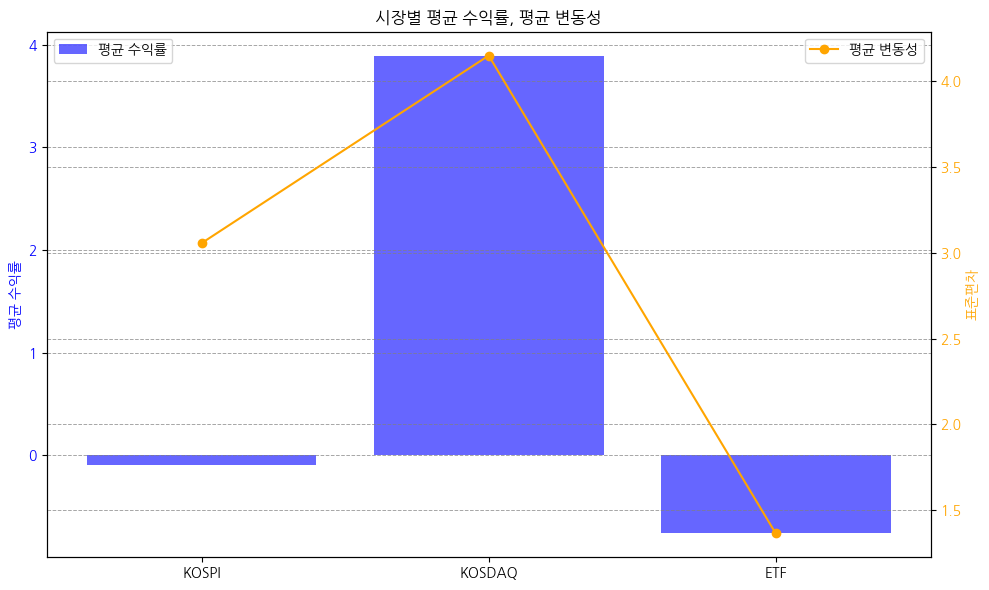

In [10]:
# 각 시장의 평균 수익률과 표준편차를 계산하는 함수

def calculate_market_statistics(month_ago=1):
    market_list = ['KOSPI', 'KOSDAQ', 'ETF']
    market_info = {market: [] for market in market_list}
    for market in market_list:
        df = load_sector_data(market)
        if df is not None:
            # 평균 수익률 및 표준편차 계산
            average_return = df['TotalReturn'].mean()
            average_volatility = df['Volatility'].mean()
            market_info[market].append((average_return, average_volatility)) 
    return market_info

# 시장 통계 계산
market_statistics = calculate_market_statistics()

# 평균 수익률 및 표준편차 추출
markets = list(market_statistics.keys())
average_returns = [market_statistics[market][0][0] for market in markets]
average_volatility = [market_statistics[market][0][1] for market in markets]

# 결과 출력
for market, avg, std in zip(markets, average_returns, average_volatility):
    print(f"{market} - 평균 수익률: {avg:.4f}, 평균 변동성: {std:.4f}")
    
# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 평균 수익률 그래프
ax1.bar(markets, average_returns, color='blue', alpha=0.6, label='평균 수익률')
ax1.set_ylabel('평균 수익률', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 이중 Y축 생성
ax2 = ax1.twinx()  
ax2.plot(markets, average_volatility, color='orange', marker='o', label='평균 변동성')
ax2.set_ylabel('표준편차', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 그리드 추가
ax1.grid(axis='y', color='gray', linestyle='--', linewidth=0.7, alpha=0.7)
ax2.grid(axis='y', color='gray', linestyle='--', linewidth=0.7, alpha=0.7)

# 제목 및 레이블 추가
plt.title('시장별 평균 수익률, 평균 변동성')
fig.tight_layout()  # 레이아웃 조정
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그래프 표시
plt.show()
